### im2col로 데이터 전개하기

합성곱 연산을 곧이곧대로 구현하려면 for 문을 겹겹이 사용해야 한다.

하지만 넘파이에서 원소에 접근할 때 for 문을 사용하지 않는 것이 성능 면에서 바람직합니다

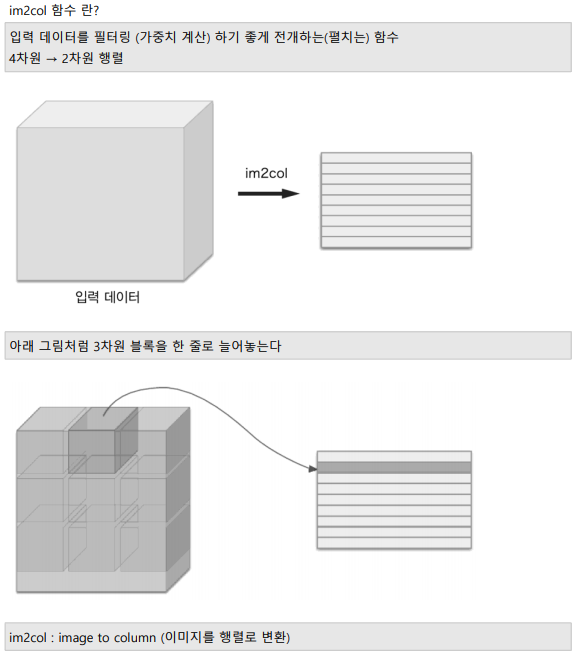

In [28]:
Image.open("C:\\Users\\QIA\\Desktop\\캡처.png")

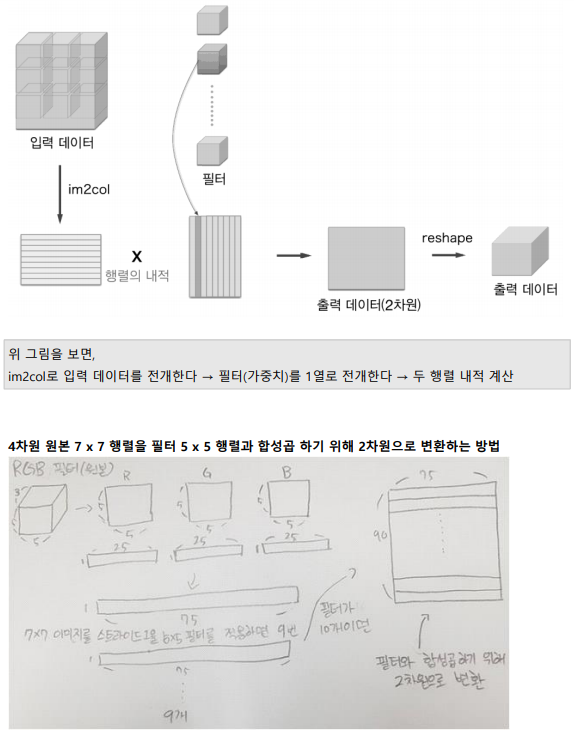

In [29]:
Image.open("C:\\Users\\QIA\\Desktop\\캡처.png")

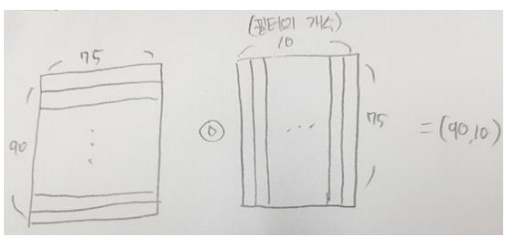

In [30]:
Image.open("C:\\Users\\QIA\\Desktop\\캡처.png")

### 합성곱 계층 구현하기

문제 210) common/util.py 안에 im2col 함수를 사용해서 아래 4차원 행렬을 2차원으로 변경하시오

    4차원 　　　　　→ 　　　2차원
    (1, 3, 7, 7) 　　　　　　(9, 75)

In [31]:
import numpy as np
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    Returns
    -------
    col : 2차원 배열
    """
    
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    for y in range(filter_h):
        y_max = y + stride * out_h
    for x in range(filter_w):
        x_max = x + stride * out_w
        col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col
a = np.random.rand(1,3,7,7)
col = im2col(a,5,5,stride=1,pad=0)
print(col.shape)

(9, 75)


문제 218) 아래의 3차원 행렬을 2차원 행렬로 변경하시오

    보기)

(10, 3, 25) → (10, 75)

In [32]:
import numpy as np
filter2 = np.random.rand(10, 3, 5, 5)
print(filter2.shape)
a = filter2.reshape(10, 3, -1)
print(a.shape)
b = a.reshape(10, -1)
print(b.shape)

(10, 3, 5, 5)
(10, 3, 25)
(10, 75)


문제 220) 책 246 페이지에 나오는 Convolution 클래스를 생성하시오


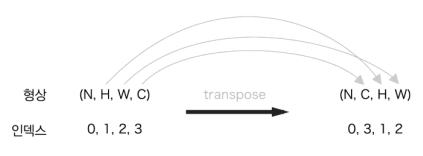

In [33]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개
        out = np.dot(col, col_W) + self.b
        print('out.shape:', out.shape)

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out
Image.open("C:\\Users\\QIA\\Desktop\\캡처.png")

문제 221) 위에서 만든 Convolution 클래스를 객체화 시켜서 Convolution 층을 구현하시오


out.shape: (90, 10)
f.shape= (10, 10, 3, 3)


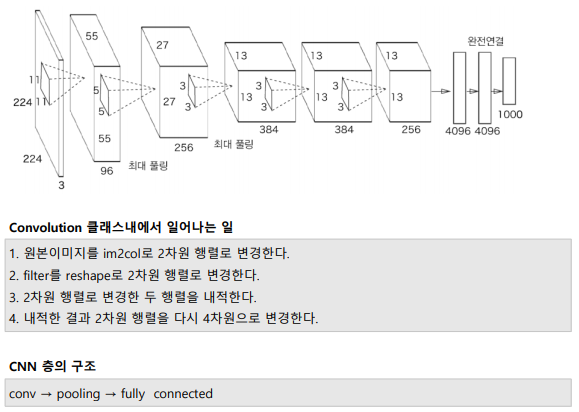

In [36]:
x1 = np.arange(1470).reshape(10,3,7,7)
W1 = np.arange(750).reshape(10,3,5,5)
b1 = 1
conv = Convolution(W1,b1)
f = conv.forward(x1)
print ('f.shape=', f.shape)
Image.open("C:\\Users\\QIA\\Desktop\\캡처.png")

### 풀링 계층 구현하기

##### 최대 풀링이 일어나는 과정

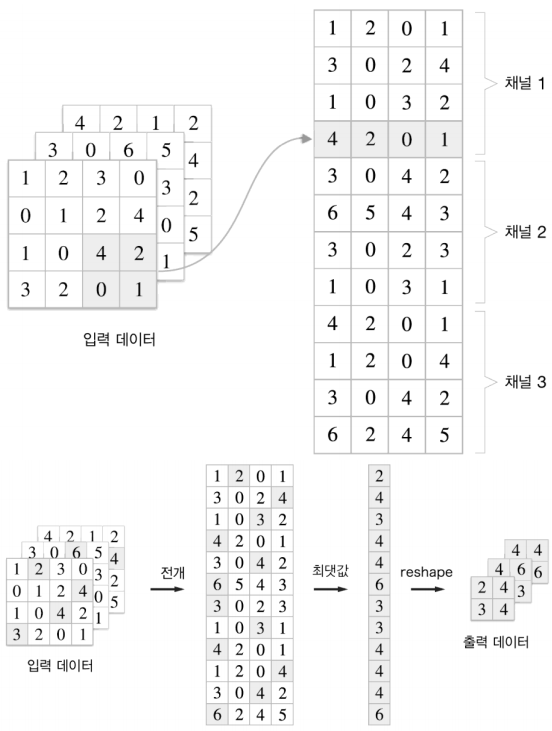

In [37]:
Image.open("C:\\Users\\QIA\\Desktop\\캡처.png")

문제 223) max_pooling 함수를 이용해서 4x4 행렬을 2x2 행렬로 변경하시오

[[0.86775445 0.712471  ]
 [0.8724158  0.86263579]]


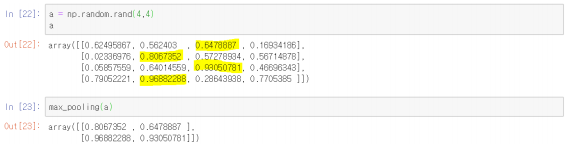

In [39]:
# max_pooling 함수 생성
def max_pooling(array):
    res = []
    a = array.flatten()
    for i in range(0,12,2):
        if i==4 or i==6:
            continue
        temp=np.array([a[i:i+2], a[i+4:i+6]])
        res.append(np.max(temp))
    res = np.array(res).reshape(2,2)
    return res

a = np.random.rand(4,4)
print(max_pooling(a))
Image.open("C:\\Users\\QIA\\Desktop\\캡처.png")

문제 227) MNIST 데이터를 CNN으로 구현했을때의 신경망을 그림으로 확인하시오

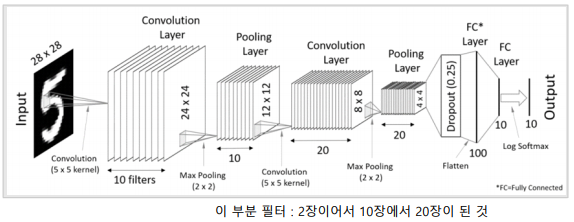

In [40]:
Image.open("C:\\Users\\QIA\\Desktop\\캡처.png")

## CNN 구현하기

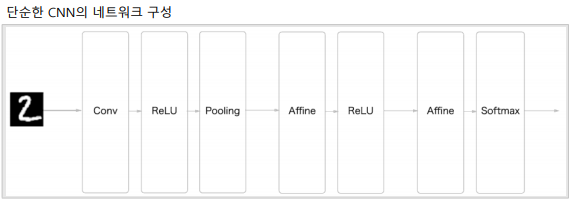

In [41]:
Image.open("C:\\Users\\QIA\\Desktop\\캡처.png")

문제 228) 위의 간단한 CNN 구현 코드를 구현하시오


In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer
class SimpleConvNet:
    """단순한 합성곱 신경망
    conv - relu - pool - affine - relu - affine - softmax
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
    'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
    'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28),
        conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
        hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
        np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
        np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
        np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
        conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1: t = np.argmax(t, axis=1)
        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i * batch_size:(i + 1) * batch_size]
            tt = t[i * batch_size:(i + 1) * batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)
        return acc / x.shape[0]
    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
        grads['W1']、grads['W2']、... 각 층의 가중치
        grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)
        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])
        return grads
    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
        grads['W1']、grads['W2']、... 각 층의 가중치
        grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            # 결과 저장
            grads = {}
            grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
            grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
            grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads
    # 최적화 시킨 파라미터를 저장
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
    # 저장한 파라미터 로드
    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i + 1)]
            self.layers[key].b = self.params['b' + str(i + 1)]

    
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
# 시간이 오래 걸릴 경우 데이터를 줄인다.
# x_train, t_train = x_train[:5000], t_train[:5000]
# x_test, t_test = x_test[:1000], t_test[:1000]
max_epochs = 20
network = SimpleConvNet(input_dim=(1, 28, 28),
                        conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 하이퍼파라미터
iters_num = 10000 # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100 # 미니배치 크기
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch) # 600

for i in range(iters_num): # 10000
    # 미니배치 획득 # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려고
    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.
        print(x_train.shape) # 60000,784
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개 16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc) # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

Saved Network Parameters!
600.0
(60000, 1, 28, 28)


문제 230) 위의 CNN을 이용한 3층 신경망에 배치정규화를 적용하시오

In [ ]:
# 계층 생성
self.layers = OrderedDict()
self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'],
conv_param['pad'])
self.layers['BatchNorm1'] = BatchNormalization(gamma=1.0, beta=0.)
self.layers['Relu1'] = Relu()
self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
self.layers['BatchNorm2'] = BatchNormalization(gamma=1.0, beta=0.)
self.layers['Relu2'] = Relu()
self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
self.last_layer = SoftmaxWithLoss()